In [1]:
import os
import shutil
# np.set_printoptions(threshold=np.inf)
import math
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# toute cette première partie c'est juste pour créer des dossiers 
# et sous-dossiers qui recevront les différents sets d'images 
# (oui c'est un peu moche comme code mais bon au moins c'est automatique et on est sûr d'avoir la même chose)

def newDir(path,newName):
    directory = os.path.join(path, newName)
    os.mkdir(directory)
    return directory

# ici faut mettre le path vers le dossier contenant toutes les images de mitochondries
# ce dossier contenant lui même dans deux sous-dossiers séparés sains/sick (oui je sais je mélange fr/en)
original_dataset_dir = "/home/tom/Downloads/dogs-vs-cats/train" 
# et là le path vers un dossier général (où vous voulez) où les différents sets d'images seront copiés.
base_dir = "/home/tom/Documents/CNN_dc"

train_dir = newDir(base_dir,'train')
validation_dir = newDir(base_dir,'validation')
test_dir = newDir(base_dir,'test')

train_sain_dir = newDir(train_dir,'sain')
train_sick_dir = newDir(train_dir,'sick')

validation_sain_dir = newDir(validation_dir,'sain')
validation_sick_dir = newDir(validation_dir,'sick')

test_sain_dir = newDir(test_dir,'sain')
test_sick_dir = newDir(test_dir,'sick')

# normalement à ce stade on a 3 dossiers avec chacun 2 sous-dossiers sain/sick

In [4]:
# Cette partie sert à séparer nos images en 3 sets (pour chacun de nos dossiers training/validation/test)

# cette fonction copie simplement un nombre d'images d'un dossier à un autre
def copyImgs(fromDir,toDir,fromNum,toNum):
    for i in range(fromNum,toNum):
        src = os.path.join(fromDir, os.listdir(fromDir)[i])
        dst = os.path.join(train_cats_dir, fname)
        shutil.copyfile(src,dst)

sainDir = os.path.join(original_dataset_dir, "sain")
sickDir = os.path.join(original_dataset_dir, "sick")

#images saines
copyImgs(sainDir,train_sain_dir,0,1000)
copyImgs(sainDir,validation_sain_dir,1000,1500)
copyImgs(sainDir,test_sain_dir,1500,2000)

#images sick
copyImgs(sickDir,train_sick_dir,0,1000)
copyImgs(sickDir,validation_sick_dir,1000,1500)
copyImgs(sickDir,test_sick_dir,1500,2000)

# à ce stade pour cet exemple j'avais un training set de 2000 images avec 1000 sain et 1000 sick
# idem pour validation et test mais avec seulement 1000 (500+500)

FileNotFoundError: [Errno 2] No such file or directory: '/home/tom/Downloads/dogs-vs-cats/train/sain'

In [ ]:
# dans cette partie on formate les images pour pouvoir les feed au réseau.
# Il faut: 1.lire les images, 2.decoder les pixels et les mettre dans tableau, 3.convertir en vecteur
# 4.passer des valeurs entre 0 à 255 à  des valeurs entre 0 et 1
# mais on a de la chance parce que tout ça est déjà prévu par Keras dans ImageDataGenerator et flow_from_directory

# rescale toutes les images
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


def genRead(generator,directory,batch=20,shuffle=True):
    gen = generator.flow_from_directory(
        directory, # dossier dans lesquels sont les images
        target_size=(150,150), # resize toutes les images en plus petit (mais c'est arbitraire le 150*150)
        batch_size=batch, # nombre d'images qui sont traitées à la fois dans une boucle de training
        shuffle=shuffle, # pour ajouter de l'aléatoire dans le training
        class_mode='binary') #binary parce qu'on veut que des 0 = sain ou 1=sick
    return gen

train_generator = genRead(train_datagen,train_dir)
validation_generator = genRead(validation_datagen,validation_dir)
#pour le test on passe à bach de 1 car on veut prédire chaque image 1 par 1 et shuffle=False car pas besoin
test_generator = genRead(test_datagen,test_dir,batch=1,shuffle=False)
test_generator.reset()

for data_batch,labels_batch in train_generator:
    print('data batch shape', data_batch.shape)
    print('labels batch shape', labels_batch.shape)
    break

In [26]:
# Création du réseau de neurones en lui-même avec assemblage de couches successives
# voir tuto comme par exemple sur ce site: https://fr.blog.businessdecision.com/tutoriel-deep-learning-le-reseau-neuronal-convolutif-cnn/
# pour comprendre les rôles de ces couches

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid')) #sigmoid car on veut que des 0 ou 1

2022-02-22 17:15:15.643719: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-22 17:15:15.644737: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-22 17:15:15.647901: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [28]:
# on choisit l'algorithme de deep learning que l'on veut et quel type de retour de performance on souhaite (ici 'accuracy')
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['acc'])

In [33]:
# on lance le training
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=2, validation_data=validation_generator, validation_steps=50)

/home/tom/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-02-22 17:34:32.301363: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-22 17:34:32.322687: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1094400000 Hz


Epoch 1/30
100/100 [==============================] - 190s 2s/step - loss: 0.8439 - acc: 0.5207 - val_loss: 0.6751 - val_acc: 0.5890
Epoch 2/30
100/100 [==============================] - 192s 2s/step - loss: 0.6922 - acc: 0.5671 - val_loss: 0.6367 - val_acc: 0.6250
Epoch 3/30
100/100 [==============================] - 191s 2s/step - loss: 0.6669 - acc: 0.6215 - val_loss: 0.6012 - val_acc: 0.6790
Epoch 4/30
100/100 [==============================] - 192s 2s/step - loss: 0.6042 - acc: 0.6637 - val_loss: 0.5832 - val_acc: 0.6800
Epoch 5/30
100/100 [==============================] - 191s 2s/step - loss: 0.5302 - acc: 0.7398 - val_loss: 0.7472 - val_acc: 0.6350
Epoch 6/30
100/100 [==============================] - 192s 2s/step - loss: 0.5242 - acc: 0.7390 - val_loss: 0.5563 - val_acc: 0.7100
Epoch 7/30
100/100 [==============================] - 192s 2s/step - loss: 0.4525 - acc: 0.7952 - val_loss: 0.6495 - val_acc: 0.7100
Epoch 8/30
100/100 [==============================] - 208s 2s/step - 

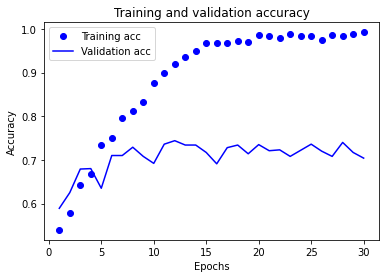

In [35]:
# On récupère l'accuracy lors du training et l'étape de validation associée
history_dict = history.history
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1,len(acc_values)+1)

# on affiche les deux dans un beau graphique
plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [45]:
# une fois qu'on a entrainé notre réseau on peut lui faire faire des prédictions en une ligne de code:
predictions = (model.predict_generator(test_generator, steps= 1) > 0.50).astype(int)
# si supérieur à 0.5 de proba il affiche 1 = sick et sinon 0 = sain

[[0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
